In [1]:
import numpy as np

def extract_subgrid(rivxnl, left, right, bottom, top):
    """ランダムにサブグリッドを抜き出す"""
    grid = np.arange(1, 4320*2160+1).reshape(2160, 4320)
    # ランダムな起点を選択（サブグリッドが範囲内に収まるように）
    resolution = 12
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    # サブグリッドを抽出
    subgrid = grid[upperindex:lowerindex, leftindex:rightindex]
    sorted_values = np.sort(subgrid.flatten())
    subrivnxl = rivxnl[upperindex:lowerindex, leftindex:rightindex]
    return sorted_values, subrivnxl

def map_original_to_new_l(sorted_values, original_l):
    """オリジナルL座標を新しいL座標に変換"""
    # ソート済み配列から対応するインデックスを取得
    index = np.searchsorted(sorted_values, original_l)
    # 対応するインデックスが範囲外の場合をチェック
    if index < len(sorted_values) and sorted_values[index] == original_l:
        return index + 1  # 1から始まるL座標
    else:
        return -1  # 該当する値が存在しない場合

city_num = 4
tag = '.mx5'
left = -106
right = -97
bottom = 19
top = 24
MASKED_FILE = f"/mnt/c/Users/tsimk/Downloads/dotfiles/h08/region/dat/riv_nxl_/masked/masked_{city_num:08}.CAMA.gl5"
#
rivnxl = np.fromfile(MASKED_FILE, dtype='float32').reshape(2160, 4320)
sorted_values, subrivnxl = extract_subgrid(rivnxl, left, right, bottom, top)
save_grid = np.zeros(subrivnxl.shape, dtype=int)
for i in range(subrivnxl.shape[0]):
    for j in range(subrivnxl.shape[1]):
        original_l = int(subrivnxl[i, j])
        new_l = map_original_to_new_l(sorted_values, original_l)
        save_grid[i, j] = new_l
# 
savefile = f"/mnt/c/Users/tsimk/Downloads/dotfiles/h08/region/dat/riv_nxl_/rivnxl.CAMA{tag}"
save_grid.astype(np.float32).tofile(savefile)
print(f'{savefile} is saved')

/mnt/c/Users/tsimk/Downloads/dotfiles/h08/region/dat/riv_nxl_/rivnxl.CAMA.mx5 is saved


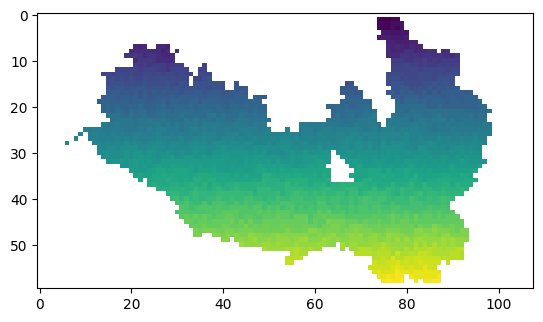

In [2]:
import matplotlib.pyplot as plt
masked = np.ma.masked_where(save_grid <= 0, save_grid)
plt.imshow(masked)

In [3]:
import os
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS
from matplotlib.patches import Rectangle

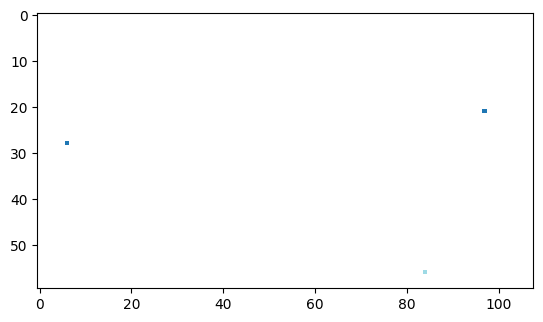

In [4]:
resolution = 12
dtype = 'float32'
gl5shape = (2160, 4320)
nx, ny = (right - left)*resolution, (top - bottom)*resolution
rgnshape = (ny, nx)
img_extent = (left, right, bottom, top)
upperindex = (90-top)*resolution
lowerindex = (90-bottom)*resolution
leftindex = (180+left)*resolution
rightindex = (180+right)*resolution
root_dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/region'
glob_dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
rivnxl_path = f"{root_dir}/dat/riv_nxl_/rivnxl.CAMA{tag}"
rivnum_path = f"{root_dir}/dat/riv_num_/rivnum.CAMA{tag}"
rivara_path = f"{root_dir}/dat/riv_ara_/rivara.CAMA{tag}"
lndmsk_path = f"{root_dir}/dat/lnd_msk_/lndmsk.CAMA{tag}"
rivmou_path = f"{root_dir}/dat/riv_mou_/rivmou.CAMA{tag}"
ctymsk_path = f"/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_msk_/city_clrd0000.gl5"
g_rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(rgnshape)
g_rivnxl = np.ma.masked_where(g_rivnxl >= 1e20, g_rivnxl)
g_rivnxl = np.ma.masked_where(~np.isfinite(g_rivnxl) | (g_rivnxl == 0), g_rivnxl)
g_rivnum = np.fromfile(rivnum_path, 'float32').reshape(rgnshape)
g_rivnum = np.ma.masked_where(g_rivnum >= 1e20, g_rivnum)
g_rivnum = np.ma.masked_where(~np.isfinite(g_rivnum) | (g_rivnum == 0), g_rivnum)
g_rivara = np.fromfile(rivara_path, 'float32').reshape(rgnshape)
g_rivara = np.ma.masked_where(g_rivara >= 1e20, g_rivara)
g_rivara = np.ma.masked_where(~np.isfinite(g_rivara) | (g_rivara == 0), g_rivara)
g_lndmsk = np.fromfile(lndmsk_path, 'float32').reshape(rgnshape)
g_ctymsk = np.fromfile(ctymsk_path, 'float32').reshape(gl5shape)
ctymsk_cropped = g_ctymsk[upperindex:lowerindex, leftindex:rightindex]
ctymsk_cropped = np.where(ctymsk_cropped==city_num, 1, 0)
dtype = [('rivara', 'float32'), ('rivnum', 'float32')]
g_ara_num = np.empty(g_rivara.shape, dtype=dtype)
g_ara_num['rivara'] = g_rivara
g_ara_num['rivnum'] = g_rivnum
rivmou_estimated = np.ma.masked_all(g_ara_num.shape, dtype='float32')
unique_values, counts = np.unique(g_rivnum.compressed(), return_counts=True)
value_counts_dict = dict(zip(unique_values, counts))
for rivnum_id in value_counts_dict.keys():
    matching_positions = np.where(g_ara_num['rivnum'] == rivnum_id)
    max_rivara_postion = np.argmax(g_ara_num['rivara'][matching_positions])
    rivmou_estimated[matching_positions[0][max_rivara_postion], matching_positions[1][max_rivara_postion]] = rivnum_id
plt.imshow(rivmou_estimated, cmap='tab20')
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)
vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
result = np.empty(g_rivnxl.shape, dtype=tuple)
mask = ~np.isnan(g_rivnxl)
result[mask] = vfunc(g_rivnxl[mask], a=ny, b=nx)
result_list = []
for row in result:
    for x, y in row:
        result_list.append((x, y))
result_shape = (result.shape[0], result.shape[1], 2)
result_array = np.array(result_list).reshape(result_shape)
result_array = result_array.astype(int)
result_dict = {}
unique_ids = np.unique(rivmou_estimated.compressed())
riv_path_array = np.ma.masked_all(rivmou_estimated.shape, dtype='float32')
visited_coords = set()
for uid in unique_ids:
    coords_a = np.argwhere(rivmou_estimated == uid)
    riv_path_array[coords_a[0][0], coords_a[0][1]] = uid
    if coords_a.size > 0:
        target_coord = tuple(coords_a[0])
        path_coords = [target_coord]
        for _ in range(300):
            if target_coord in visited_coords:
                break
            visited_coords.add(target_coord)
            matched_coords = np.argwhere(np.all(target_coord == result_array, axis=2))
            if len(matched_coords) == 0:
                break
            unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
            if not unvisited_matched:
                break
            rivara_values = [g_rivara[coord[0], coord[1]] for coord in unvisited_matched]
            max_index = np.argmax(rivara_values)
            best_coord = unvisited_matched[max_index]
            riv_path_array[best_coord[0], best_coord[1]] = uid
            target_coord = best_coord
            path_coords.append(target_coord)
        result_dict[uid] = path_coords

In [5]:
#---------------------------------------------------------------------------------------------------------------
#  city maskの枠だけを表示
#---------------------------------------------------------------------------------------------------------------
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3, zorder=0):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=zorder+1) # top
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=zorder+2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=zorder+1) # bottom
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=zorder+2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=zorder+1) # left
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=zorder+2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=zorder+1) # right
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=zorder+2) # right

    return ax
    
def get_unique_non_masked_values(values):
    result = []
    for value in np.unique(values):
        if value is not np.ma.masked and not np.isnan(value):
            result.append(value)
    return result

def is_whiteish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return (r + g + b) / 3 > 230  # Check if the average is above the threshold

def is_grayish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    deviation = max(r, g, b) - min(r, g, b)
    return deviation <= 20

def is_blueish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return  b - r > 120 and b - g > 120  # If blue is dominant and significantly larger

def get_filtered_colors(all_colors):
    result = []
    for color in all_colors:
        if color != '#00FFFF' and not is_whiteish(color) and not is_grayish(color) and not is_blueish(color):
            result.append(color)
    return result

def make_cmap(Rivnum_masked_array):
    # ユニークな流域の数をカウント
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)

    # 流域に固有の色を割り振る
    all_colors = list(CSS4_COLORS.values())
    filtered_colors = get_filtered_colors(all_colors)
    colors_list = filtered_colors[:num_colors]

    # -1<=x<0に透明色を追加
    colors_list.insert(0, '#00000000')

    # HTMLカラーコードに変化してlisted colormap を作成
    cmap = ListedColormap(colors_list)

    # [辞書作る] key=流域ID, value=0から数えたindex　
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i

    return num_colors, index_dict, cmap

def get_index(val, index_dict):
    return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1

{112.0: 0, 164.0: 1, 1366.0: 2}
(-106, -97, 19, 24)


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


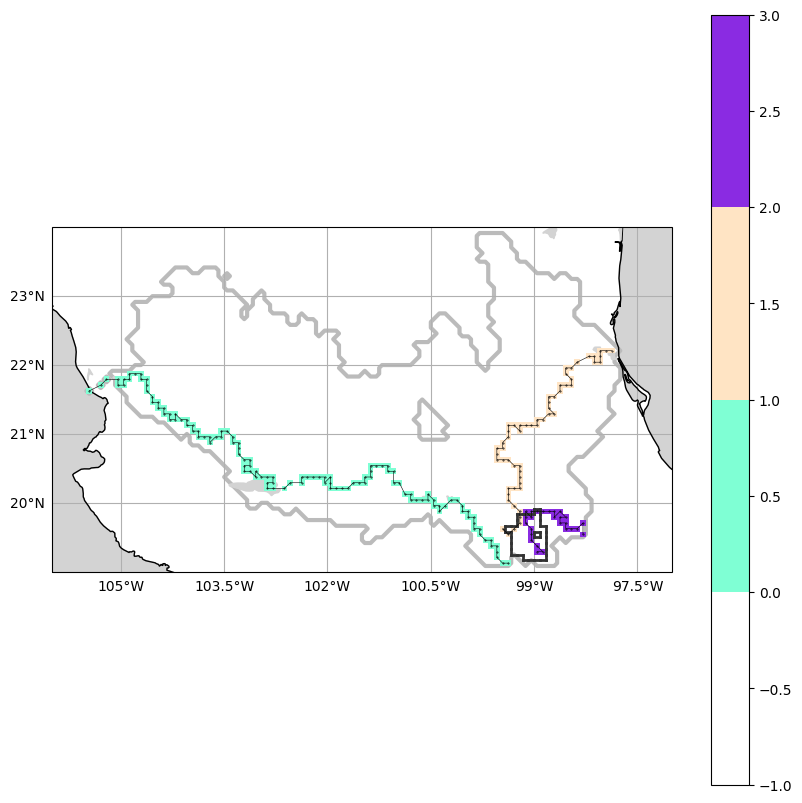

In [6]:
def path_zorder_citymask(data, g_mask_cropped, Rivnum_masked_array, result_dict, city_mask):
    data = np.where(data<1e20, data, -1)
    
    num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
    print(index_dict)
    
    indexed_data = np.vectorize(get_index)(data, index_dict)
    
    #
    lonmin_rgn, lonmax_rgn, latmin_rgn, latmax_rgn = left, right, bottom, top
    extent = (lonmin_rgn, lonmax_rgn, latmin_rgn, latmax_rgn)
    print(extent)
    #
    fig = plt.figure(figsize=(10, 10))
    projection = ccrs.PlateCarree()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    ax.set_extent(extent, projection)
    
    contour = ax.contour(g_mask_cropped, levels=[0.5], colors='#BBBBBB', linewidths=3, origin='upper', extent=extent, transform=projection, zorder=0)
    
    gl = ax.gridlines(draw_labels=True, zorder=0)
    gl.top_labels = False
    gl.right_labels = False
    ax.add_feature(cfea.OCEAN, color='#d3d3d3')
    ax.add_feature(cfea.LAKES, color='#d3d3d3')
    
    img = ax.imshow(indexed_data, extent=extent, transform=projection, cmap=cmap, vmin=-1, vmax=num_colors, zorder=2)
    
    if result_dict is not None:
        for key, path in result_dict.items():
            lat_coords, lon_coords = zip(*path)
            
            # xy coordinate >>> lonlat coordinate
            lat_coords = [(latmax_rgn - lat/12 - 1/24) for lat in lat_coords]
            lon_coords = [(lonmin_rgn + lon/12 + 1/24) for lon in lon_coords]
            ax.plot(lon_coords, lat_coords, marker='o', markersize=0.4, color='black', linestyle='-', linewidth=.4, transform=projection, zorder=5)

    draw_mask_sotowaku(img_extent, city_mask, ax=ax, sotowaku_color='#333333', linewidth=2, zorder=1)
            
    fig.colorbar(img, ax=ax)

path_zorder_citymask(riv_path_array, g_lndmsk, g_rivnum, result_dict, ctymsk_cropped)